In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import joblib
import random
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as pl

In [3]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

In [4]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fatim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fatim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Load dataset
print("Loading dataset...")
dataset = load_dataset("dair-ai/emotion")
train_df = dataset["train"].to_pandas()
val_df = dataset["validation"].to_pandas()
test_df = dataset["test"].to_pandas()

Loading dataset...


In [6]:
# Show class distribution
full_df = pd.concat([train_df, val_df, test_df])
print("\nClass distribution:")
print(full_df['label'].value_counts())


Class distribution:
label
1    6761
0    5797
3    2709
4    2373
2    1641
5     719
Name: count, dtype: int64


In [7]:
# Label names
label_names = dataset['train'].features['label'].names
for i, label in enumerate(label_names):
    print(f"{i} → {label}")

0 → sadness
1 → joy
2 → love
3 → anger
4 → fear
5 → surprise


In [8]:
# Clean text function with stopword removal and lemmatization
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return " ".join(tokens)

In [9]:
# Clean text columns
print("\nCleaning text...")
train_df['text'] = train_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)


Cleaning text...


In [10]:
# Label Encoding
y_train = LabelEncoder().fit_transform(train_df['label'])
y_val = LabelEncoder().fit_transform(val_df['label'])
y_test = LabelEncoder().fit_transform(test_df['label'])
le = LabelEncoder()
y_train = le.fit_transform(train_df['label'])
y_val = le.transform(val_df['label'])
y_test = le.transform(test_df['label'])

In [11]:
# TF-IDF Vectorization
print("\nVectorizing text...")
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_df['text'])


Vectorizing text...


In [12]:
# Handle class imbalance
print("\nHandling class imbalance...")
smote_enn = SMOTEENN(random_state=42)
X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)

print("Original train shape:", X_train.shape)
print("Balanced train shape:", X_train_balanced.shape)


Handling class imbalance...
Original train shape: (16000, 13275)
Balanced train shape: (24782, 13275)


In [13]:
# Train model
print("\nTraining model...")
base_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
ovr_model = OneVsRestClassifier(base_model)
ovr_model.fit(X_train_balanced, y_train_balanced)


Training model...


OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000,
                                                 random_state=42))

In [14]:
# Evaluation
target_names = [str(label) for label in le.classes_]
print("\nValidation Set Evaluation:")
y_val_pred = ovr_model.predict(X_val)
print(classification_report(y_val, y_val_pred, target_names=target_names))
print("Accuracy:", accuracy_score(y_val, y_val_pred))

print("\nTest Set Evaluation:")
y_test_pred = ovr_model.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))
print("Accuracy:", accuracy_score(y_test, y_test_pred))


Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       550
           1       0.98      0.78      0.87       704
           2       0.71      0.98      0.83       178
           3       0.83      0.92      0.87       275
           4       0.73      0.84      0.78       212
           5       0.70      0.93      0.80        81

    accuracy                           0.86      2000
   macro avg       0.81      0.89      0.84      2000
weighted avg       0.88      0.86      0.86      2000

Accuracy: 0.8575

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       581
           1       0.98      0.76      0.86       695
           2       0.64      0.97      0.77       159
           3       0.79      0.92      0.85       275
           4       0.79      0.84      0.82       224
           5       0.56      0.91      0.69        66

    accura

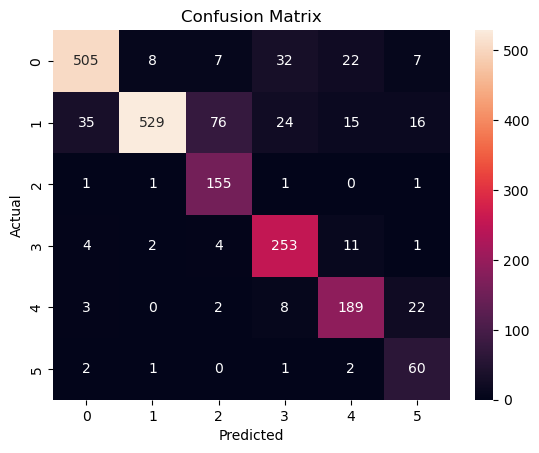

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
pl.xlabel("Predicted")
pl.ylabel("Actual")
pl.title("Confusion Matrix")
pl.show()

In [16]:
# Save components
joblib.dump(ovr_model, 'emotion_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [17]:
# Prediction on sample inputs
print("\nTesting prediction on sample input:")
sample_texts = ["I am feeling sad today!", "I am extremely joyful and excited."]
cleaned = [clean_text(text) for text in sample_texts]
X_sample = vectorizer.transform(cleaned)
preds = ovr_model.predict(X_sample)
emotions = le.inverse_transform(preds)
for text, emotion in zip(sample_texts, emotions):
    print(f"'{text}' → {label_names[emotion]}")


Testing prediction on sample input:
'I am feeling sad today!' → sadness
'I am extremely joyful and excited.' → joy


In [ ]:
# Error Analysis
misclassified = (y_test != y_test_pred)
for text, actual, predicted in zip(test_df['text'][misclassified], y_test[misclassified], y_test_pred[misclassified]):
    print(f"Text: {text}")
    print(f"Actual: {label_names[actual]} | Predicted: {label_names[predicted]}\n")


Text: explain clung relationship boy many way immature uncommitted despite excitement feeling getting accepted master program university virginia
Actual: joy | Predicted: love

Text: feel particularly agitated
Actual: fear | Predicted: anger

Text: im sure feeling loss ever go away may dull sweet feeling nostalgia shared life dad luck dad year
Actual: sadness | Predicted: love

Text: feel honoured included magzine prioritises health clean living highly im curious read magazine concerned health clean lifestyle green parent
Actual: joy | Predicted: surprise

Text: stop anxiety feel alone got distraction
Actual: sadness | Predicted: fear

Text: tried see would like liked one girl friend never really worked ever feel emotional connection friend
Actual: sadness | Predicted: love

Text: spent wandering around still kinda dazed feeling particularly sociable id hiding couple day getting little unhealthy made go cross hang folk
Actual: joy | Predicted: surprise

Text: honestly say sistahs chat 